In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spring-2024-regression-challenge/Sample_submission.csv
/kaggle/input/spring-2024-regression-challenge/Training_Dataset.csv
/kaggle/input/spring-2024-regression-challenge/Test_Dataset.csv


# Import Libraries & Read Dataset

In [2]:
import requests

url = 'https://raw.githubusercontent.com/lko9911/Kaggle/master/Compare_Regression_models.py'

r = requests.get(url)

with open('Compare_Regression_models.py', 'w') as f:
    f.write(r.text)

In [3]:
# For Compare modeling
from Compare_Regression_models import evaluate_models,show_models,plot_feature_importance

# For Standard data
from sklearn.preprocessing import StandardScaler

# For Modeling
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow_decision_forests as tfdf
import tensorflow as tf
from collections import OrderedDict
import logging
import os 

# For Evaluate model
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score

# For EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import plotly.graph_objects as go
import plotly.express as px
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

2024-04-29 05:48:35.791820: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-29 05:48:35.791959: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-29 05:48:35.971204: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
df = pd.read_csv('/kaggle/input/spring-2024-regression-challenge/Training_Dataset.csv')
df

,Composition (X),Property (Y)
0,8.06,0.0742
1,1.76,0.7080
2,3.35,0.5150
3,3.79,0.7060
4,5.46,0.5030
5,1.71,0.7260
6,5.20,0.4450
7,8.31,-0.0046
8,5.08,0.4240
9,1.52,0.7280


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Composition (X)  50 non-null     float64
 1   Property (Y)     50 non-null     float64
dtypes: float64(2)
memory usage: 928.0 bytes


In [6]:
df.describe()

,Composition (X),Property (Y)
count,50.000000,50.000000
mean,5.886600,0.543336
std,2.419715,0.501293
min,1.190000,-0.151000
25%,4.152500,0.314250
50%,6.145000,0.461000
75%,8.020000,0.660750
max,9.690000,2.680000


In [7]:
df.isna().sum()

Composition (X)    0
Property (Y)       0
dtype: int64

# Data Preprocessing

In [8]:
fig = px.scatter(df, x='Composition (X)', y='Property (Y)', title='Relationship between Composition and Property',
                 labels={'Composition (X)': 'Composition', 'Property (Y)': 'Property'})
fig.update_layout(plot_bgcolor='black', paper_bgcolor='black', font=dict(color='white'))
fig.show()

In [9]:
property_y = df['Property (Y)']

Q1 = property_y.quantile(0.25)
Q3 = property_y.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

clipped_property_y = property_y.clip(lower=lower_bound, upper=upper_bound)

df['Property (Y)'] = clipped_property_y

In [10]:
fig = px.scatter(df, x='Composition (X)', y='Property (Y)', title='Relationship between Composition and Property',
                 labels={'Composition (X)': 'Composition', 'Property (Y)': 'Property'})
fig.update_layout(plot_bgcolor='black', paper_bgcolor='black', font=dict(color='white'))
fig.show()

# Compare Models

In [11]:
X = df.drop(['Property (Y)'], axis=1)
y = df['Property (Y)']

evaluate_models(X,y)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 40, number of used features: 0
[LightGBM] [Info] Start training from score 0.453488
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spli

,Model,RMSE,R²
0,Linear Regression,0.406138,-0.383207
1,Ridge Regression,0.405158,-0.376542
2,Lasso Regression,0.370574,-0.151570
3,ElasticNet,0.370574,-0.151570
4,Decision Tree Regressor,0.193483,0.686073
5,Random Forest Regressor,0.148828,0.814257
6,Support Vector Machine Regressor,0.285520,0.316383
7,K-Nearest Neighbors Regressor,0.221286,0.589373
8,Gradient Boosting Regressor,0.187336,0.705704
9,XGBoost Regressor,0.147863,0.816658


In [12]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.columns = X_train.columns.str.replace(" ", "_")  # 공백을 언더스코어로 대체
X_test.columns = X_test.columns.str.replace(" ", "_")

In [14]:
train_data = tf.data.Dataset.from_tensor_slices((dict(X_train), y_train)).batch(32)
test_data = tf.data.Dataset.from_tensor_slices((dict(X_test), y_test)).batch(32)

In [15]:
model_rf = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)
model_gbt = tfdf.keras.GradientBoostedTreesModel(task=tfdf.keras.Task.REGRESSION)
model_cart = tfdf.keras.CartModel(task=tfdf.keras.Task.REGRESSION)

model_rf.fit(train_data)
model_gbt.fit(train_data)
model_cart.fit(train_data)

y_pred_rf = model_rf.predict(test_data)
y_pred_gbt = model_gbt.predict(test_data)
y_pred_cart = model_cart.predict(test_data)

mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = mse_rf ** 0.5
mse_gbt = mean_squared_error(y_test, y_pred_gbt)
rmse_gbt = mse_gbt ** 0.5
mse_cart = mean_squared_error(y_test, y_pred_cart)
rmse_cart = mse_cart ** 0.5

Use /tmp/tmpi5m25ttl as temporary training directory
Use /tmp/tmppezwsm8w as temporary training directory
Use /tmp/tmpbjz1_gzt as temporary training directory
Reading training dataset...


[WARNING 24-04-29 05:48:51.9826 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-29 05:48:51.9834 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-29 05:48:51.9834 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:06.877768. Found 40 examples.
Training model...
Model trained in 0:00:00.056200
Compiling model...


[INFO 24-04-29 05:48:58.9429 UTC kernel.cc:1233] Loading model from path /tmp/tmpi5m25ttl/model/ with prefix 2ebbd2cdd97c494a
[INFO 24-04-29 05:48:58.9587 UTC decision_forest.cc:660] Model loaded with 300 root(s), 3406 node(s), and 1 input feature(s).
[INFO 24-04-29 05:48:58.9587 UTC abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-04-29 05:48:58.9587 UTC kernel.cc:1061] Use fast generic engine


Model compiled.
Reading training dataset...
Training dataset read in 0:00:00.163691. Found 40 examples.
Training model...
Model trained in 0:00:00.026510
Compiling model...
Model compiled.


[INFO 24-04-29 05:49:09.3237 UTC kernel.cc:1233] Loading model from path /tmp/tmppezwsm8w/model/ with prefix c7c9846acad54016
[INFO 24-04-29 05:49:09.3247 UTC quick_scorer_extended.cc:903] The binary was compiled without AVX2 support, but your CPU supports it. Enable it for faster model inference.
[INFO 24-04-29 05:49:09.3248 UTC abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-29 05:49:09.3248 UTC kernel.cc:1061] Use fast generic engine


Reading training dataset...
Training dataset read in 0:00:00.159337. Found 40 examples.
Training model...
Model trained in 0:00:00.013159
Compiling model...
Model compiled.


[INFO 24-04-29 05:49:09.7864 UTC kernel.cc:1233] Loading model from path /tmp/tmpbjz1_gzt/model/ with prefix 3a46dd29c7af424a
[WARNING 24-04-29 05:49:09.7868 UTC utils.cc:73] The model does not have any input features i.e. the model is constant and will always return the same prediction.
[INFO 24-04-29 05:49:09.7868 UTC decision_forest.cc:660] Model loaded with 1 root(s), 1 node(s), and 0 input feature(s).
[INFO 24-04-29 05:49:09.7869 UTC kernel.cc:1061] Use fast generic engine


1/1 [==============================] - 0s 51ms/step


In [16]:
models = {
    "RandomForestRegressor(TFDF)": model_rf,
    "GradientBoostingRegressor(TFDF)": model_gbt,
    "DecisionTreeRegressor(TFDF)": model_cart,
}

results = OrderedDict()

for name, model in models.items():
    y_pred = model.predict(test_data)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse**0.5
    r2 = r2_score(y_test, y_pred)  
    results[name] = {"RMSE": rmse, "R²": r2}

results_df = pd.DataFrame(results.values(), index=results.keys())
results_df.index.name = "Model"
results_df.reset_index(inplace=True)
results_df

1/1 [==============================] - 0s 50ms/step


,Model,RMSE,R²
0,RandomForestRegressor(TFDF),0.281605,0.334999
1,GradientBoostingRegressor(TFDF),0.328972,0.092473
2,DecisionTreeRegressor(TFDF),0.370033,-0.148208


# XGBoost Modeling

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

xgb_model = XGBRegressor()

param_dist = {
    'n_estimators': np.arange(100, 1000, 100),  
    'learning_rate': np.arange(0.01, 0.2, 0.01),  
    'max_depth': np.arange(3, 10),  
}

random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, n_iter=50, cv=3, n_jobs=-1, scoring='neg_mean_squared_error', random_state=42)

random_search.fit(X_train_scaled, y_train)

best_xgb_model = random_search.best_estimator_
print("Best parameters :", random_search.best_params_)

Best parameters : {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.02}


# Evaluating XGBoost 

In [18]:
y_pred = best_xgb_model.predict(X_test_scaled)

rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("RMSE:", round(rmse,5))
print("R²:", round(r2,5))

RMSE: 0.1404
R²: 0.83469


In [19]:
y_pred = best_xgb_model.predict(X_test_scaled)

comparison = pd.DataFrame({'actual': y_test, 'pred': y_pred})
comparison

,actual,pred
13,0.4020,0.452199
39,0.0203,0.101837
30,0.7120,0.555175
45,1.1805,1.127592
17,1.1805,1.127592
48,0.4780,0.116006
26,0.4020,0.444688
25,0.4700,0.532487
32,0.3630,0.500276
19,0.6710,0.624531


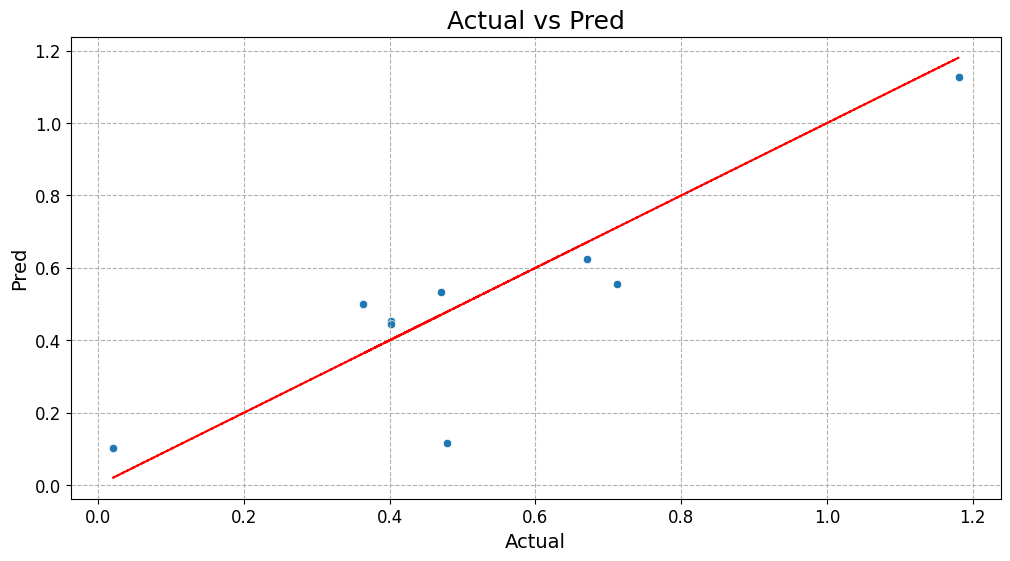

In [20]:
plt.figure(figsize=(12,6))

sns.scatterplot(x='actual', y='pred', data=comparison)
plt.plot(comparison['actual'], comparison['actual'], color='red', linestyle='--')
plt.title('Actual vs Pred', fontsize=18)
plt.xlabel('Actual', fontsize=14)
plt.ylabel('Pred', fontsize=14)
plt.xticks(rotation=0, fontsize=12)  
plt.yticks(fontsize=12)
plt.grid(linestyle='--')
plt.show()

# Submit

In [21]:
submission_A = pd.read_csv("/kaggle/input/spring-2024-regression-challenge/Test_Dataset.csv", dtype={"Composition (X)":'object'})
submission = pd.read_csv("/kaggle/input/spring-2024-regression-challenge/Test_Dataset.csv")
submission

,Composition (X)
0,0.00
1,0.01
2,0.02
3,0.03
4,0.04
...,...
945,9.96
946,9.97
947,9.98
948,9.99


In [22]:
scaler = StandardScaler()
scaler.fit(X_train)

submission_scaled = scaler.transform(submission)

In [23]:
y_pred = best_xgb_model.predict(submission_scaled)

In [24]:
submission['Property (Y)'] = y_pred  
submission['Composition (X)'] = submission_A['Composition (X)']
submission[['Composition (X)', 'Property (Y)']].to_csv('submission.csv', index=False)  

In [25]:
submission

,Composition (X),Property (Y)
0,0.000,0.478180
1,0.010,0.478180
2,0.020,0.478180
3,0.030,0.478180
4,0.040,0.478180
...,...,...
945,9.960,0.591969
946,9.970,0.591969
947,9.980,0.591969
948,9.990,0.591969
